In [ ]:
import os
import glob

In [ ]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 54.8 MB/s eta 0:00:00


In [ ]:
import rasterio
from rasterio.plot import show

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np

In [ ]:
import tensorflow.python.keras as k

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix

In [ ]:
%matplotlib inline

In [ ]:
import pandas as pd

In [ ]:
# @title Default title text
!unzip '/content/drive/MyDrive/Satellite images.zip'

Streaming output truncated to the last 5000 lines.
  inflating: 2750/River/River_145.jpg  
  inflating: 2750/River/River_1450.jpg  
  inflating: 2750/River/River_1451.jpg  
  inflating: 2750/River/River_1452.jpg  
  inflating: 2750/River/River_1453.jpg  
  inflating: 2750/River/River_1454.jpg  
  inflating: 2750/River/River_1455.jpg  
  inflating: 2750/River/River_1456.jpg  
  inflating: 2750/River/River_1457.jpg  
  inflating: 2750/River/River_1458.jpg  
  inflating: 2750/River/River_1459.jpg  
  inflating: 2750/River/River_146.jpg  
  inflating: 2750/River/River_1460.jpg  
  inflating: 2750/River/River_1461.jpg  
  inflating: 2750/River/River_1462.jpg  
  inflating: 2750/River/River_1463.jpg  
  inflating: 2750/River/River_1464.jpg  
  inflating: 2750/River/River_1465.jpg  
  inflating: 2750/River/River_1466.jpg  
  inflating: 2750/River/River_1467.jpg  
  inflating: 2750/River/River_1468.jpg  
  inflating: 2750/River/River_1469.jpg  
  inflating: 2750/River/River_147.jpg  
  inflati

In [ ]:
dataset_url = '/content/2750'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [ ]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [ ]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


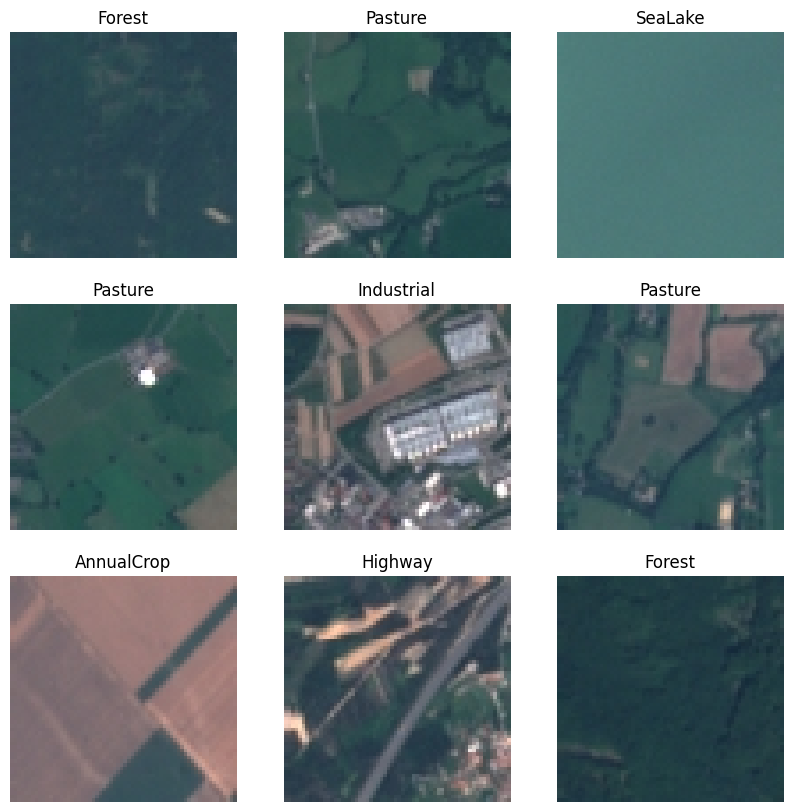

In [ ]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [ ]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
      # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)


    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
model = ResNet50(input_shape=(64,64,3), classes=10)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# (epochs=100)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=25, batch_size=32)

Epoch 1/25
675/675 [==============================] - 87s 74ms/step - loss: 1.4692 - accuracy: 0.5642 - val_loss: 1.0084 - val_accuracy: 0.6631
Epoch 2/25
675/675 [==============================] - 49s 72ms/step - loss: 1.2768 - accuracy: 0.5906 - val_loss: 1.5251 - val_accuracy: 0.5669
Epoch 3/25
675/675 [==============================] - 47s 69ms/step - loss: 0.9860 - accuracy: 0.6773 - val_loss: 0.9986 - val_accuracy: 0.7000
Epoch 4/25
675/675 [==============================] - 48s 70ms/step - loss: 0.8930 - accuracy: 0.7146 - val_loss: 0.9350 - val_accuracy: 0.6893
Epoch 5/25
675/675 [==============================] - 47s 69ms/step - loss: 0.7630 - accuracy: 0.7462 - val_loss: 0.7187 - val_accuracy: 0.7487
Epoch 6/25
675/675 [==============================] - 47s 69ms/step - loss: 0.7207 - accuracy: 0.7648 - val_loss: 0.6739 - val_accuracy: 0.7602
Epoch 7/25
675/675 [==============================] - 48s 71ms/step - loss: 0.6168 - accuracy: 0.7925 - val_loss: 0.5894 - val_accuracy:

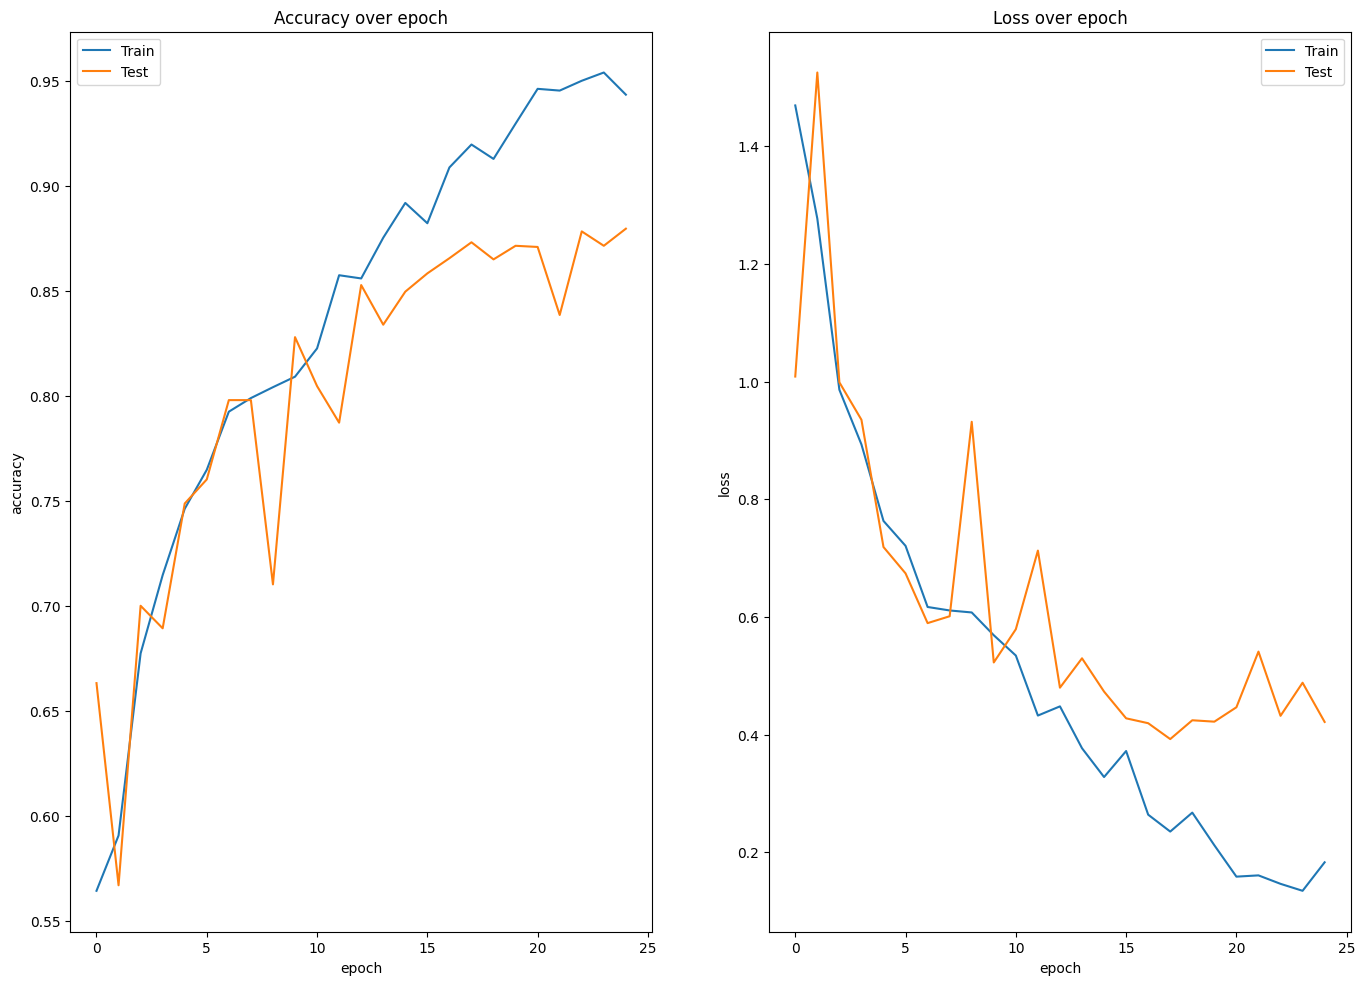

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 48ms/step


In [ ]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[ 936,    3,   18,    8,    1,   36,   46,    1,   14,    6],
       [   6, 1002,   12,    0,    0,   30,    0,    0,    8,    9],
       [  14,   18,  862,   18,   13,   15,   83,   21,   15,    1],
       [  12,    0,   11,  740,   46,   16,   27,   16,   24,    0],
       [   0,    0,    1,    8,  848,    0,   16,   24,    2,    0],
       [  18,   11,   15,    8,    0,  612,   26,    2,   11,    1],
       [  38,    1,   79,   16,   17,   31,  708,   15,   12,    0],
       [   0,    0,    3,    7,   29,    0,    7, 1021,    0,    0],
       [  57,   11,    9,   53,   12,   24,   17,    2,  699,    2],
       [  18,   10,    3,    0,    0,    2,    0,    0,    7, 1023]])

In [ ]:
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 936    3   18    8    1   36   46    1   14    6]
 [   6 1002   12    0    0   30    0    0    8    9]
 [  14   18  862   18   13   15   83   21   15    1]
 [  12    0   11  740   46   16   27   16   24    0]
 [   0    0    1    8  848    0   16   24    2    0]
 [  18   11   15    8    0  612   26    2   11    1]
 [  38    1   79   16   17   31  708   15   12    0]
 [   0    0    3    7   29    0    7 1021    0    0]
 [  57   11    9   53   12   24   17    2  699    2]
 [  18   10    3    0    0    2    0    0    7 1023]]


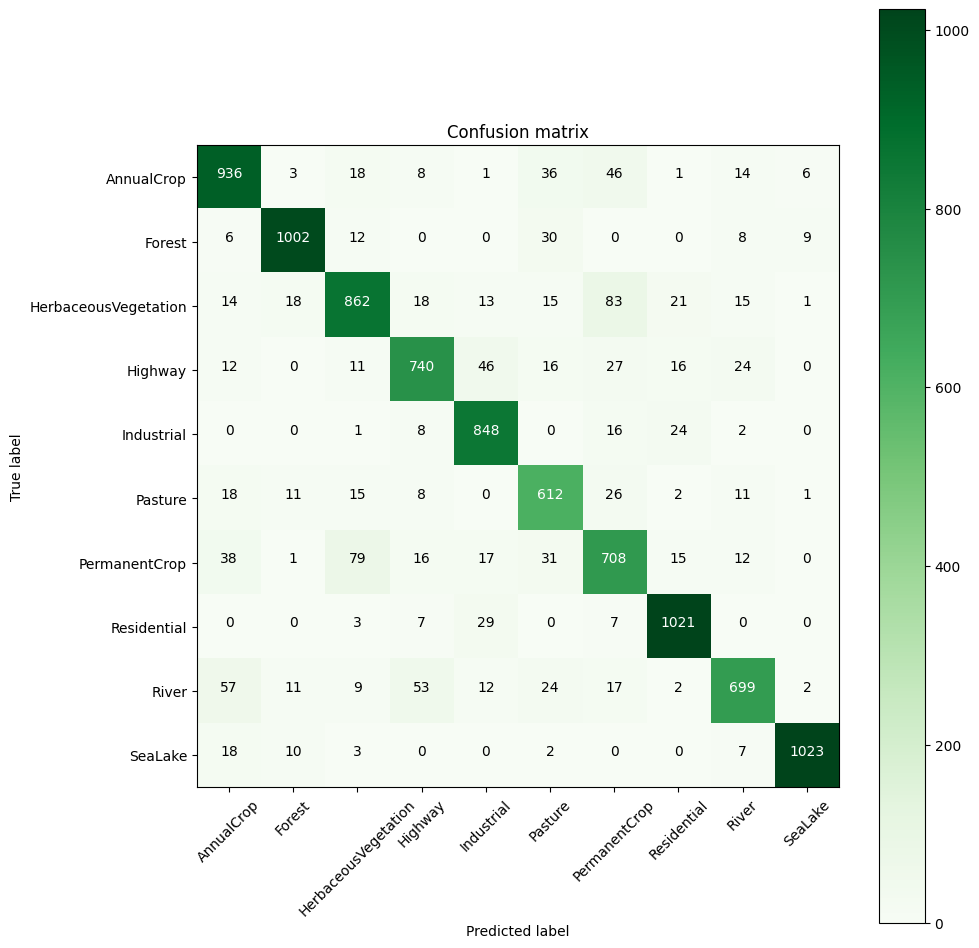

In [ ]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Greens')